In [22]:
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G,color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,node_color=color,cmap= "Set2")
    plt. show()

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h=h.detach().cpu().numpy()
    plt.scatter(h[:,0],h[:,1],s=140,c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss:{loss.item():.4f}', fontsize=16)
    plt.show()

In [23]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
print (f'Dataset:{dataset}:')
print('========================')
print (f'Number of graphs: {len(dataset)}')
print (f'Number of features:{dataset.num_features}')
print (f'Number of classes:{dataset.num_classes}')

Dataset:KarateClub():
Number of graphs: 1
Number of features:34
Number of classes:4


In [24]:
data = dataset[0]# Get the first graph object.
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [25]:
edge_index= data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

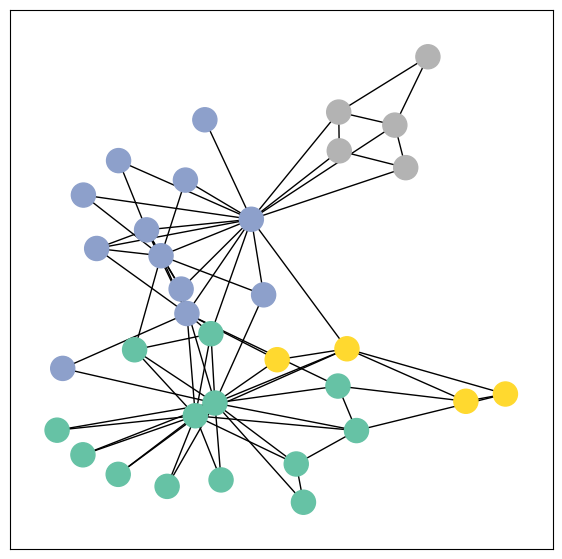

In [26]:
from torch_geometric.utils import to_networkx
G=to_networkx(data, to_undirected=True)
visualize_graph(G,color=data.y)

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__ (self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1=GCNConv(dataset.num_features,4)
        self.conv2=GCNConv(4,4)
        self.conv3=GCNConv(4,2)
        self.classifier =Linear(2,dataset.num_classes)

    def forward(self,x,edge_index):
        h=self.conv1(x,edge_index)
        h=h.tanh()
        h=self.conv2(h,edge_index)
        h=h. tanh()
        h=self.conv3(h,edge_index)
        h=h.tanh()
        # 分类层
        out = self.classifier(h)
        return out,h

model=GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape:[34, 2]


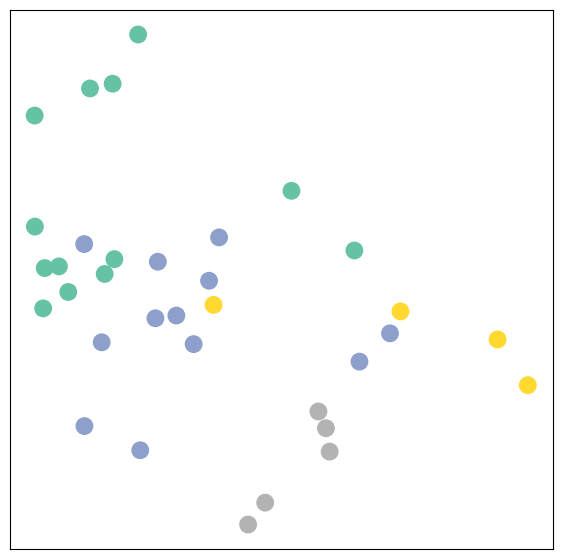

In [28]:
model=GCN()

_,h=model(data.x, data.edge_index)
print(f'Embedding shape:{list(h.shape)}')
visualize_embedding(h,color=data.y)

训练模型semi-supervised

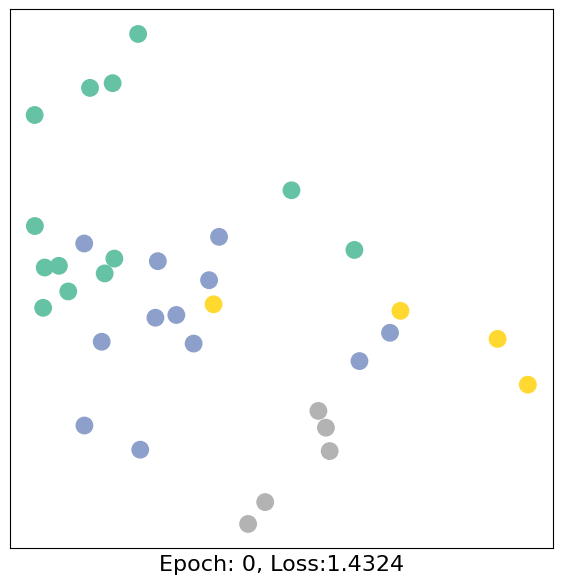

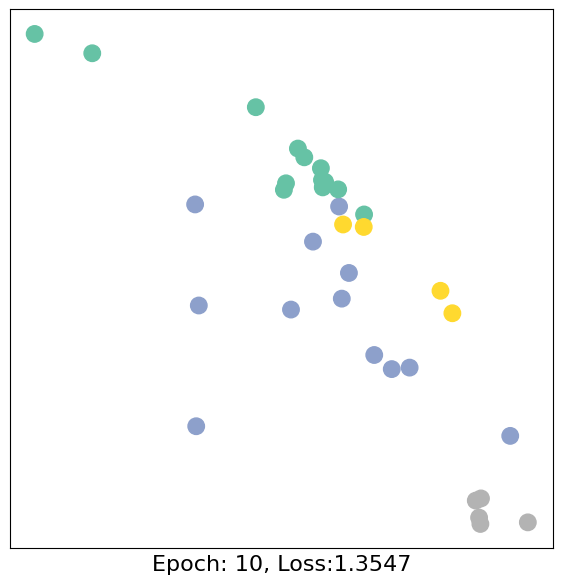

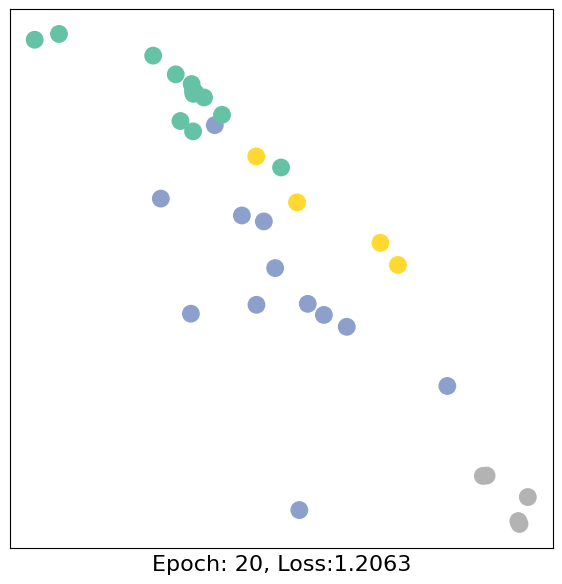

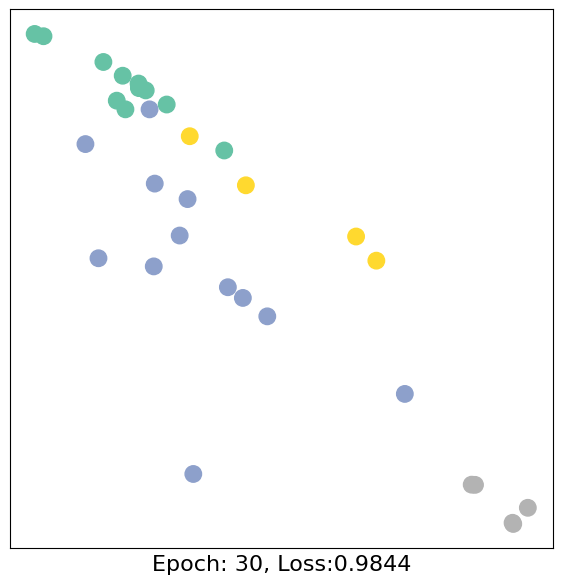

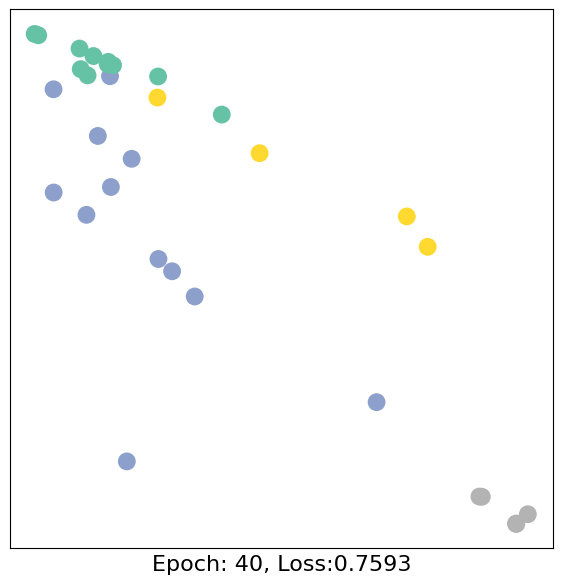

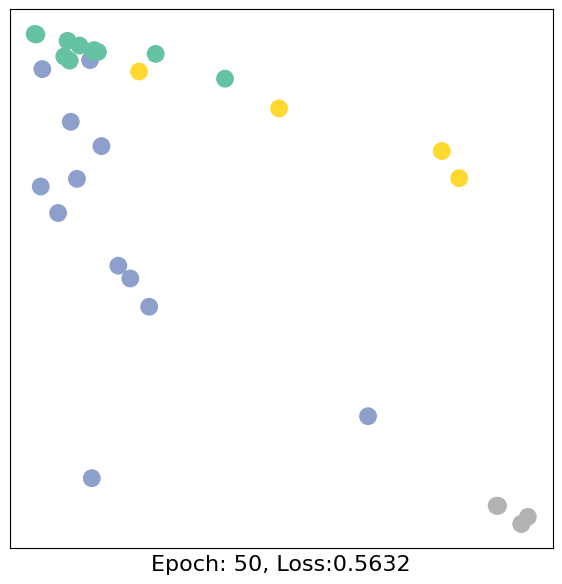

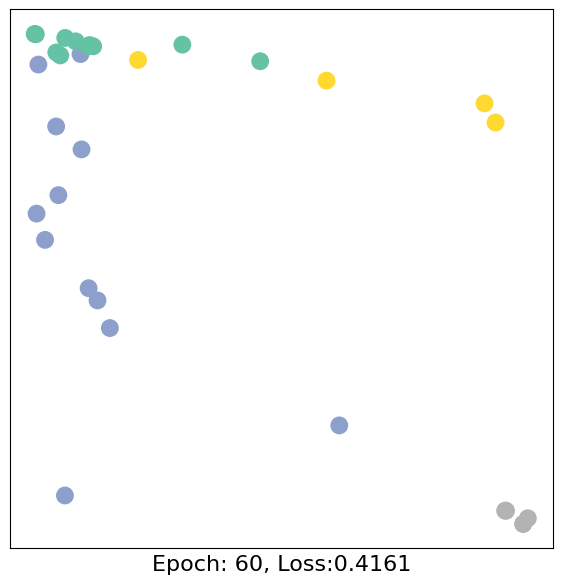

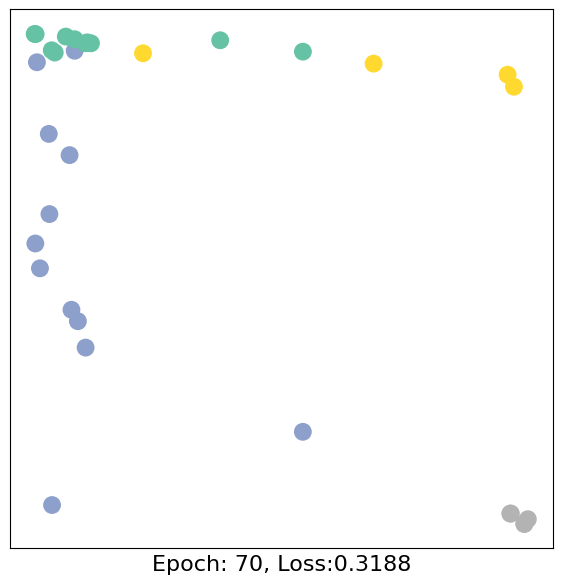

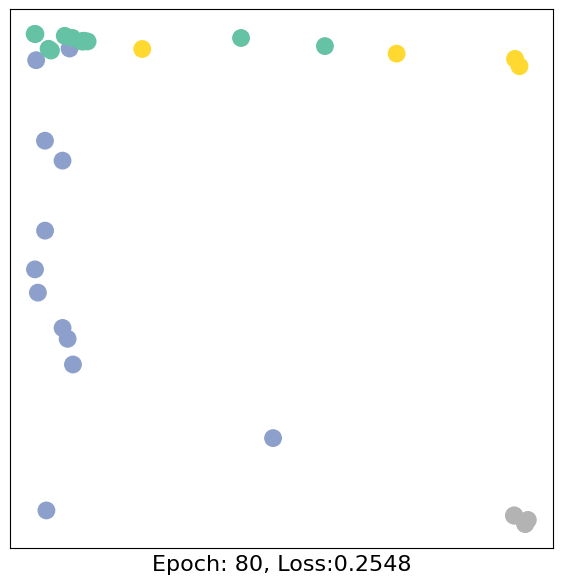

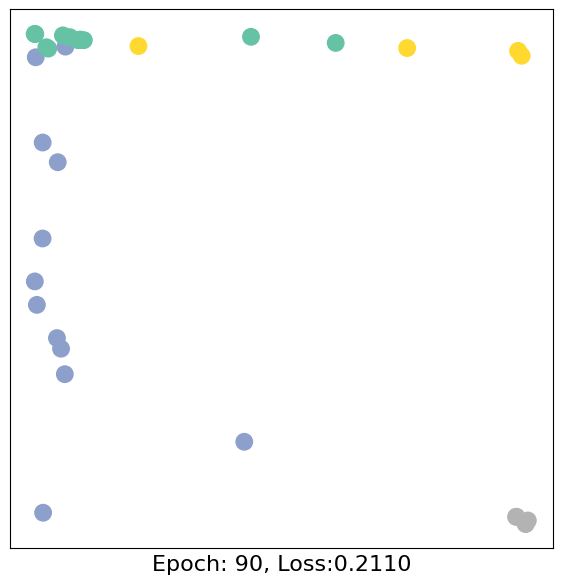

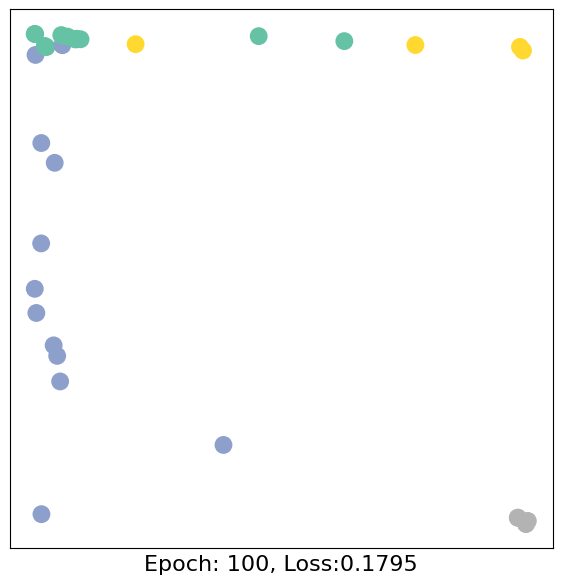

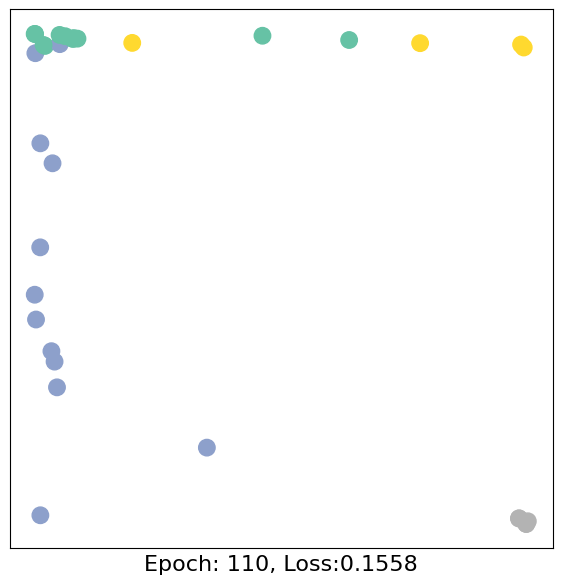

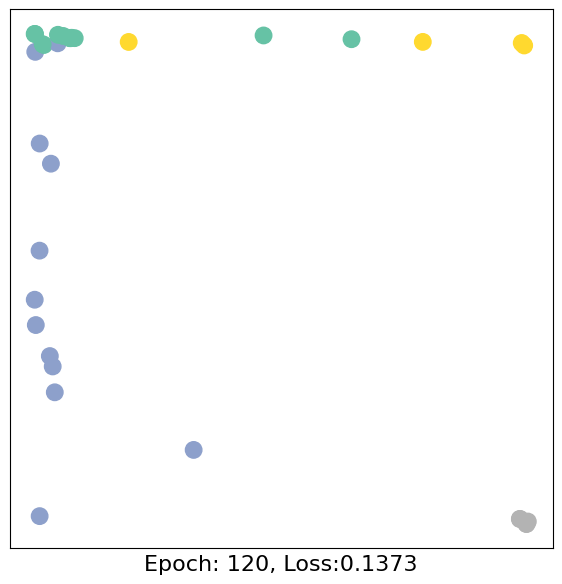

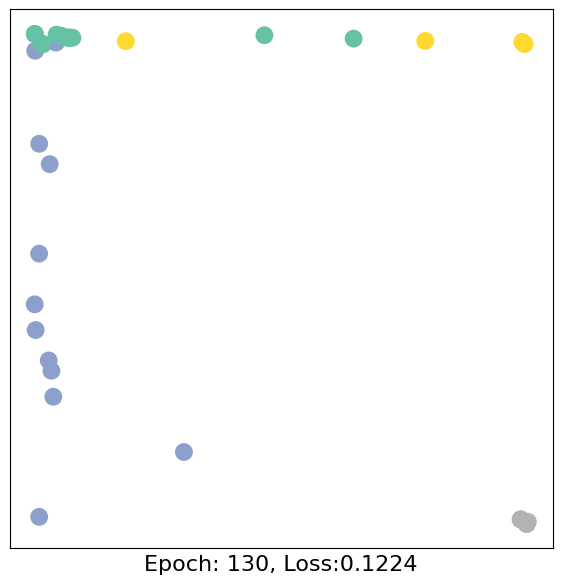

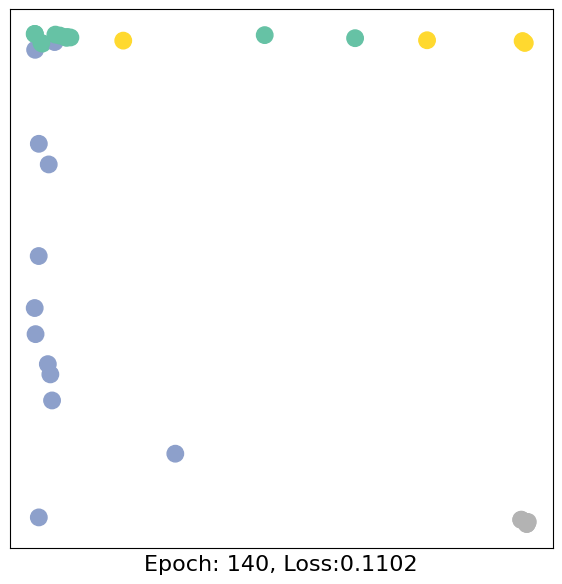

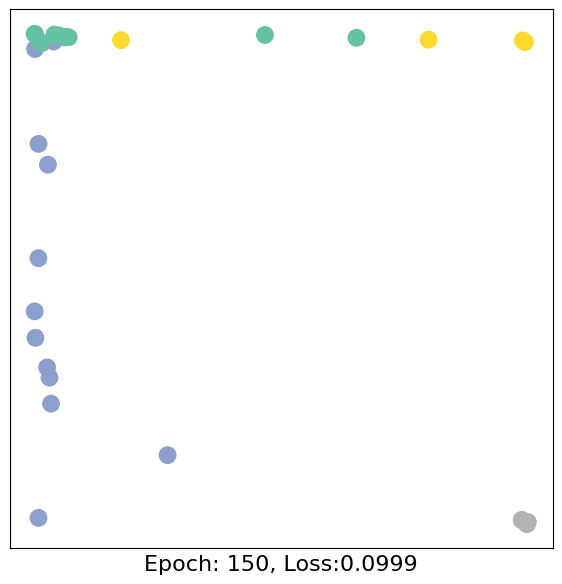

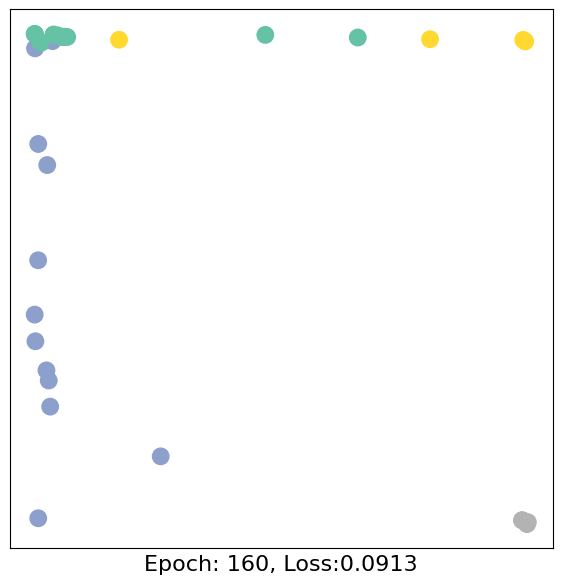

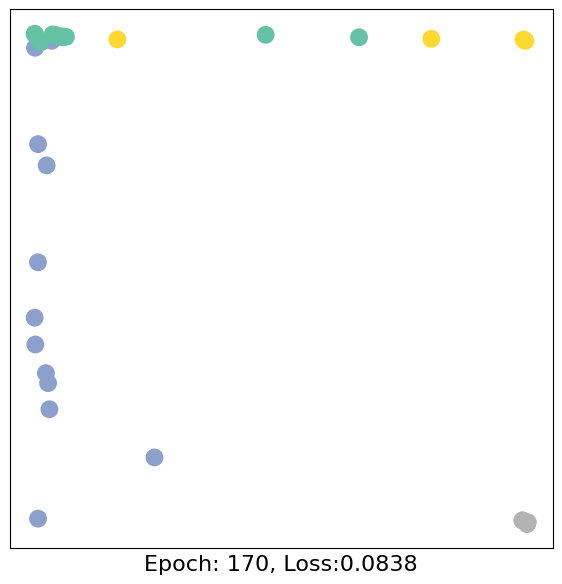

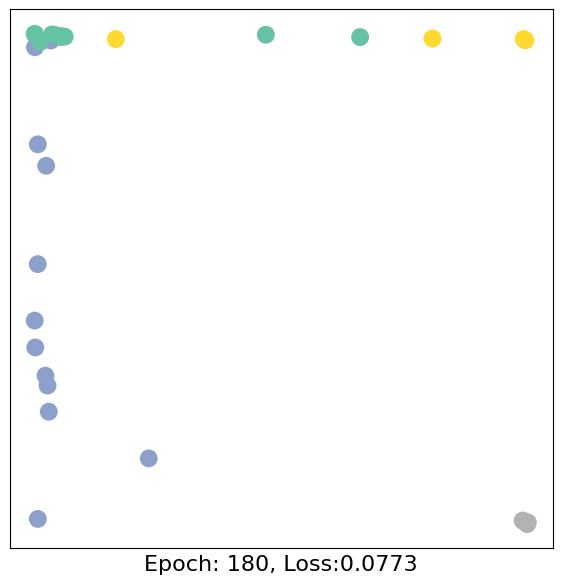

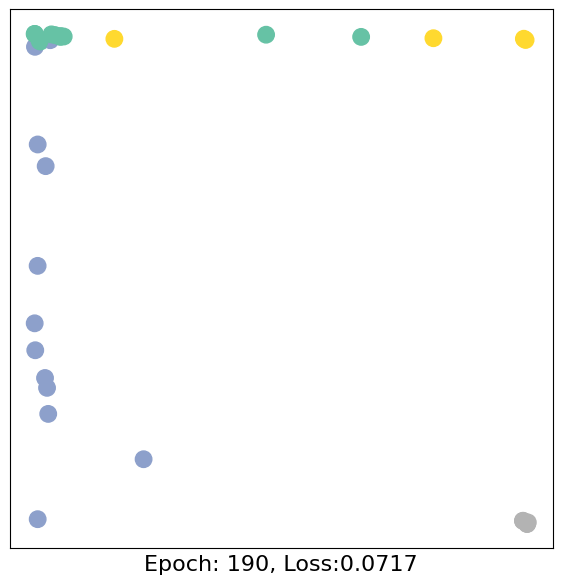

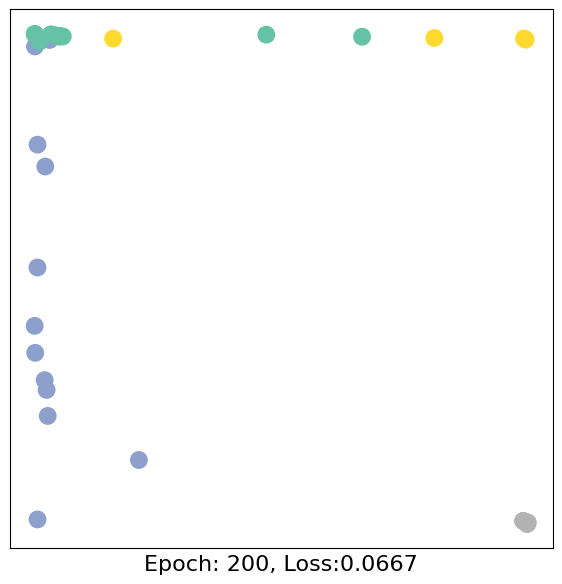

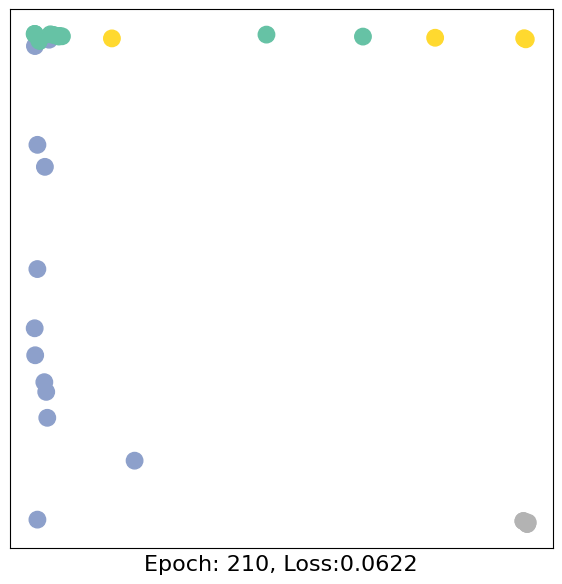

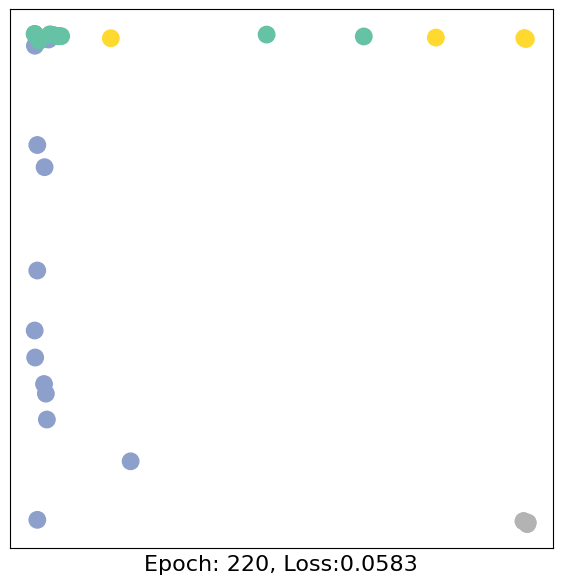

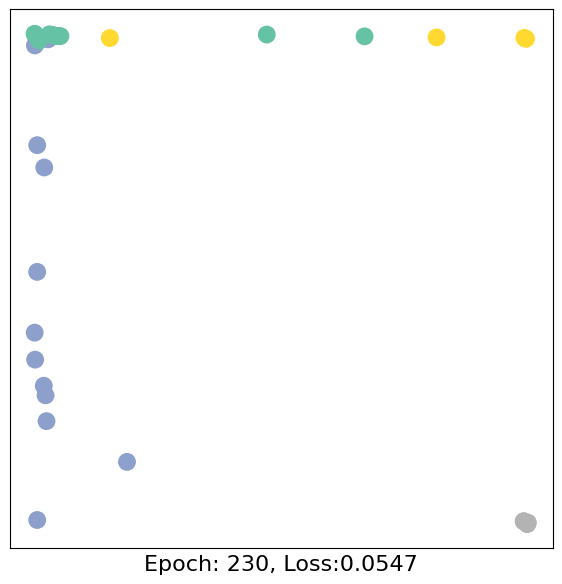

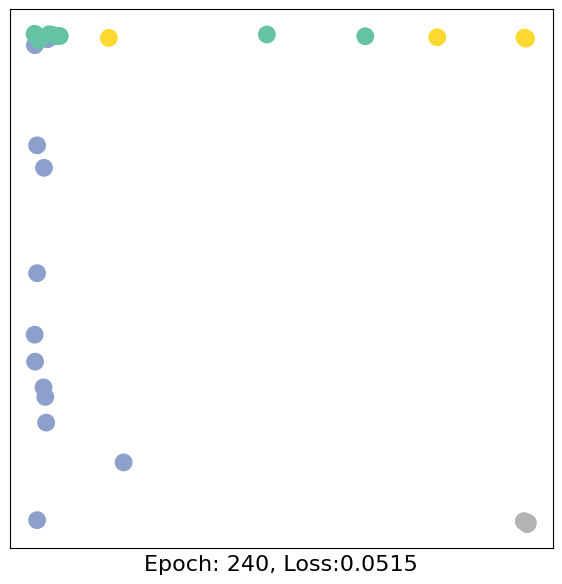

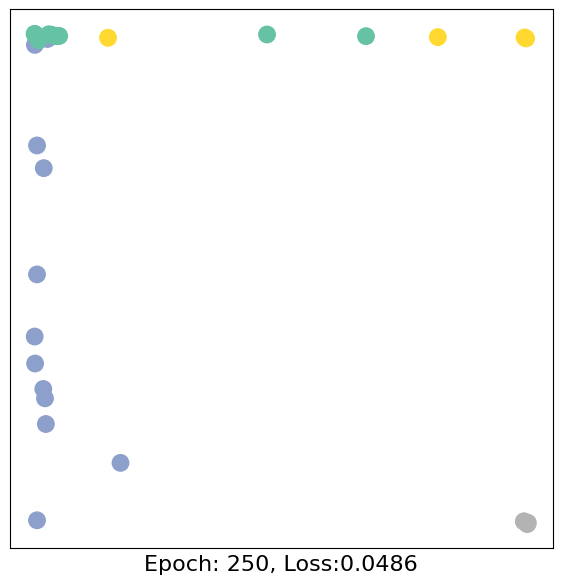

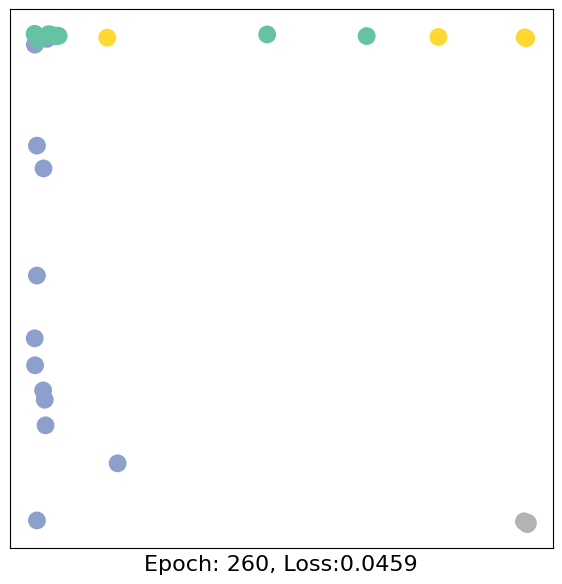

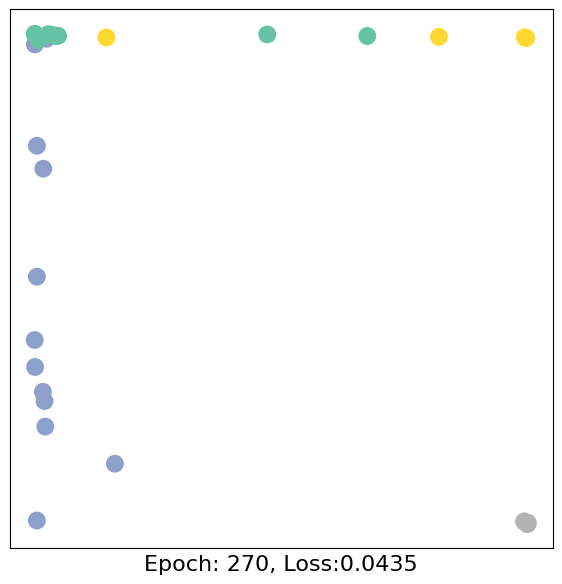

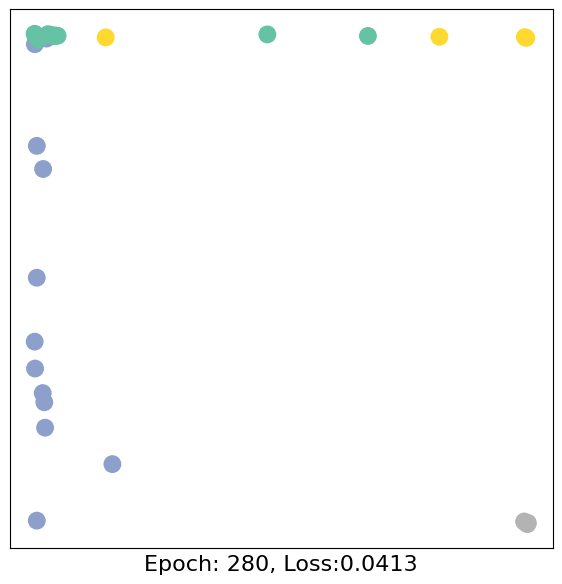

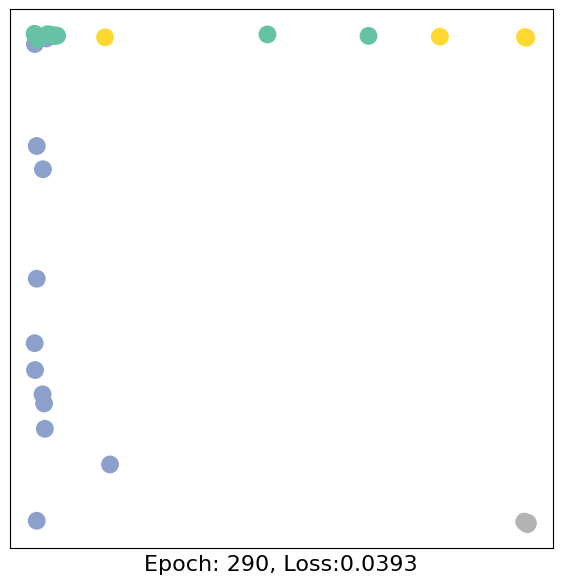

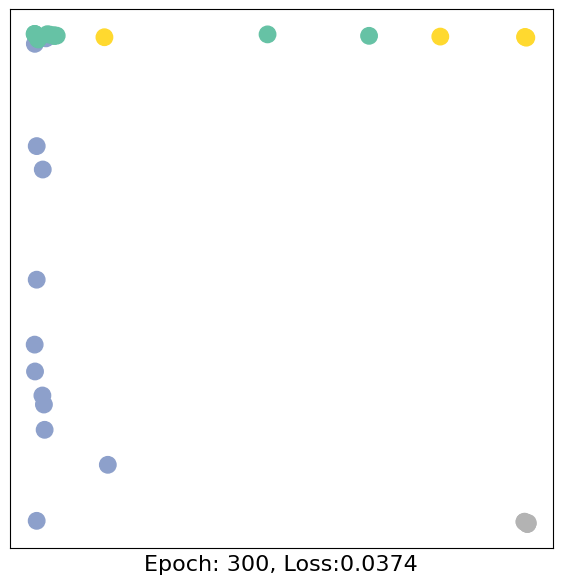

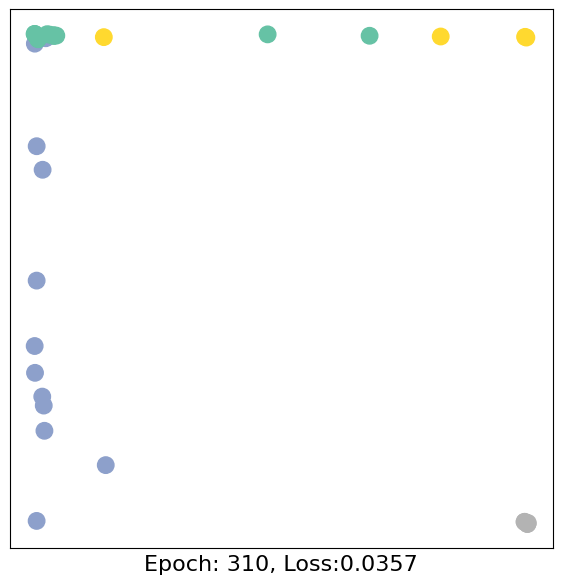

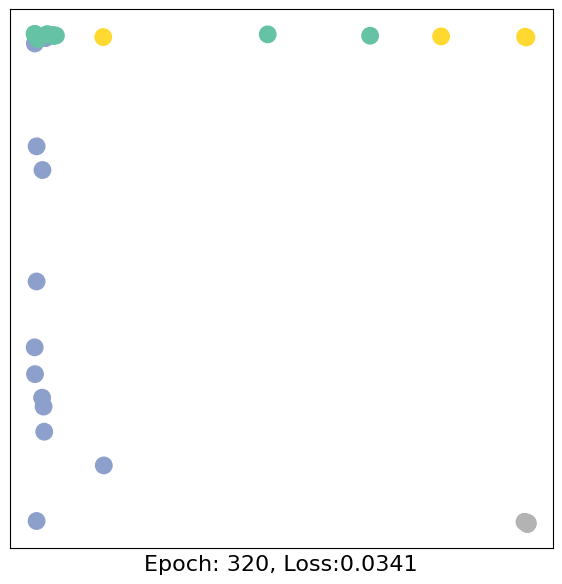

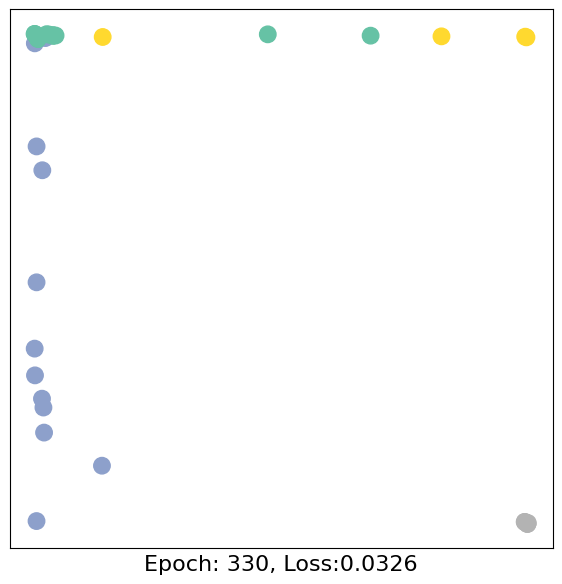

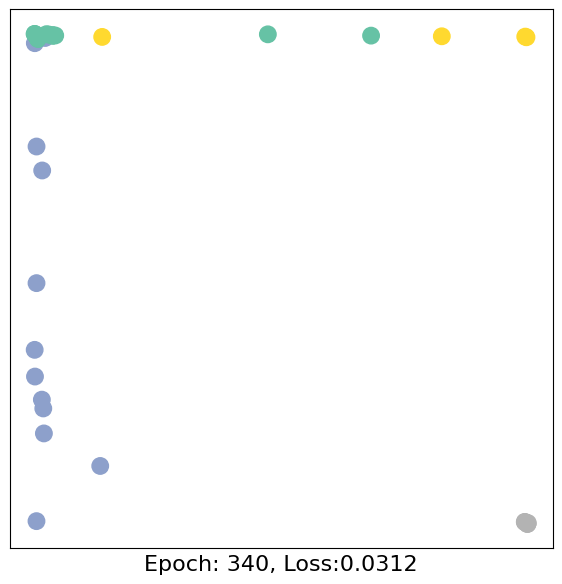

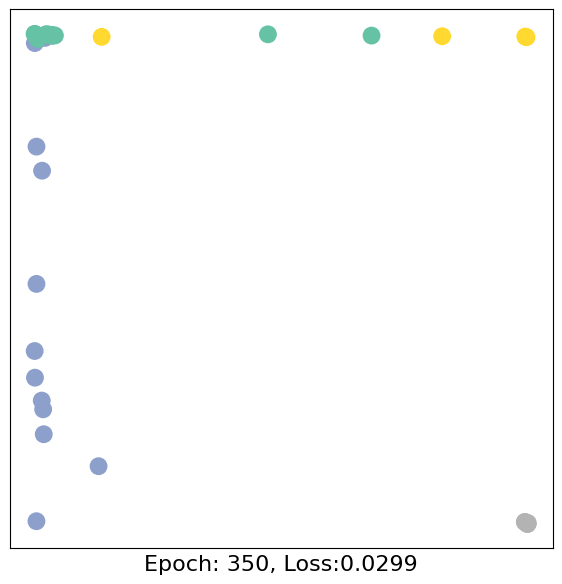

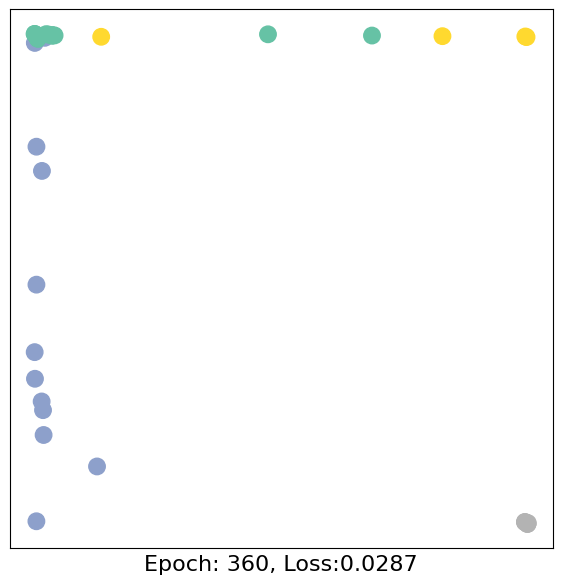

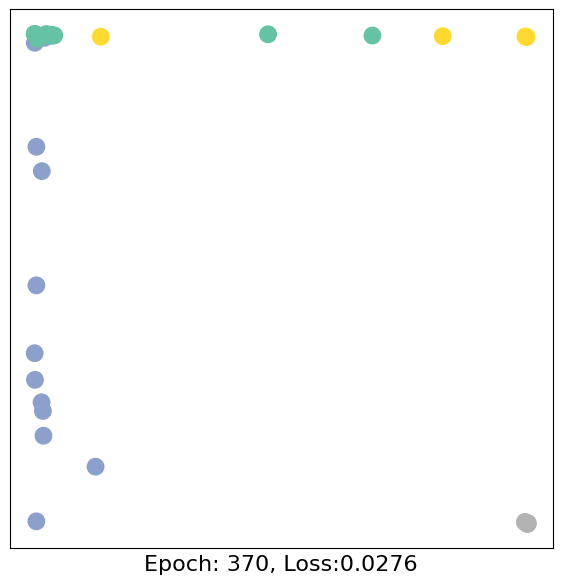

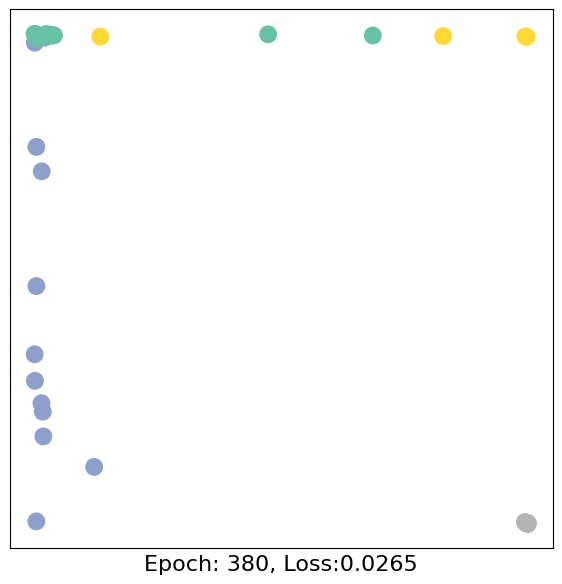

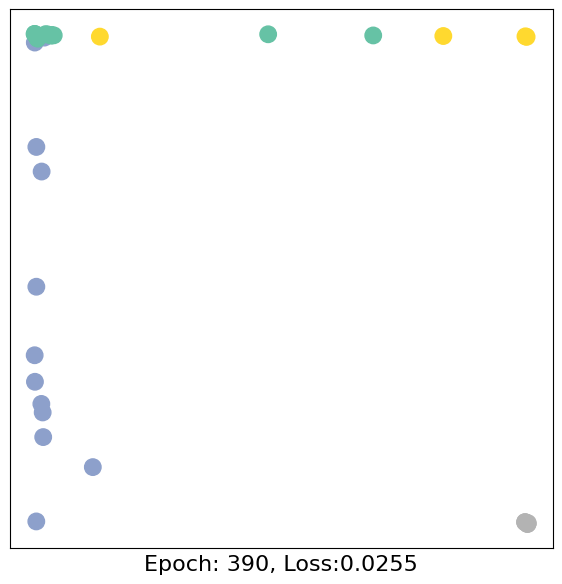

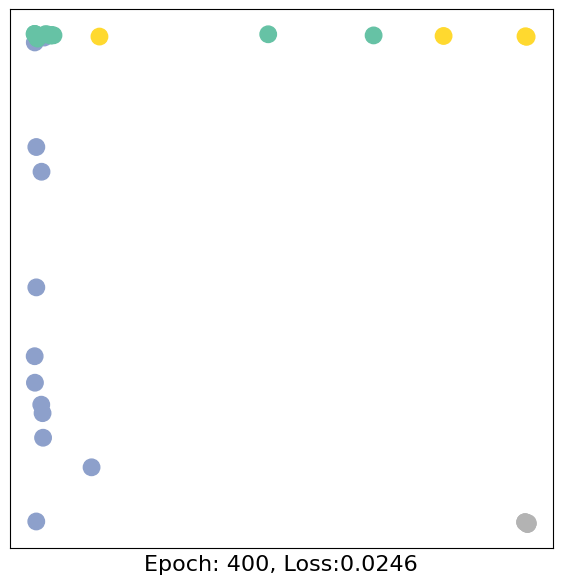

In [30]:
import time

model=GCN()
criterion = torch.nn.CrossEntropyLoss() # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)# Define optimizer.

def train(data):
    optimizer.zero_grad()
    out,h= model(data.x,data.edge_index)#h是两维向量，主要是为了咱们画个图
    loss = criterion(out[data.train_mask], data.y[data.train_mask])# semi-supervised
    loss.backward()
    optimizer.step()
    return loss,h

for epoch in range(401):
    loss, h= train(data)
    if epoch %10 ==0:
        visualize_embedding(h,color=data.y,epoch=epoch, loss=loss)
        time.sleep(0.3)